In [51]:
import warnings
warnings.filterwarnings('ignore')
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from sklearn.decomposition import NMF
from tensorly.decomposition import non_negative_parafac

In [3]:
def cleaning(df, user_type=None, add_user_age=True):

    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ', '')

    df = df.dropna(subset=['birthyear'])

    if user_type is not None:
        assert user_type in ['Subscriber', 'Customer']
        df = df.query('usertype==@user_type')

    df = df.query('startstationlongitude!=0')
    df = df.query('startstationlatitude!=0')
    df = df.query('endstationlongitude!=0')
    df = df.query('endstationlatitude!=0')

    df.loc[:, 'starttime'] = pd.to_datetime(df.starttime)
    df.loc[:, 'stoptime'] = pd.to_datetime(df.stoptime)
    df.loc[:, 'year'] = df.starttime.dt.year
    df.loc[:, 'hour'] = df.starttime.dt.hour
    df.loc[:, 'weekday'] = df.starttime.dt.weekday.astype(str).str.cat(
        df.starttime.dt.day_name().str[:3], sep='-')
    df.loc[:, 'weekday-hour'] = df.hour.astype(str).str.cat(
        df.starttime.dt.day_name().str[:3], sep='-')

    if add_user_age:
        df.loc[:, 'user_age'] = df.year - df.birthyear
        df = df.query('user_age>=0')
        df = df.query('user_age<=80')

    return df


In [4]:
def load_data(date=None, date_from=None, date_to=None, clean=True):
    """
        date: (str) e.g., '201701'
    """

    if date is not None:
        zip_file = zipfile.ZipFile(
            f'../rawdata/{date}-citibike-tripdata.csv.zip')
        data = pd.read_csv(zip_file.open(zip_file.namelist()[0]))
        # data = pd.read_csv(f'../rawdata/{date}-citibike-tripdata.csv.zip', compression='zip')
        if clean:
            return cleaning(data)
        else:
            return data

    else:
        if date_from is not None and date_to is not None:
            return pd.concat([load_data(date=date.strftime("%Y%m"))
                              for date in pd.date_range(start=date_from, end=date_to, freq='M')])
        else:
            return None


In [5]:
df = load_data('201701')

In [6]:
def df2tts(df, time_key, facets, values=None, sampling_rate="D"):
    """ Convert a DataFrame (list) to tensor time series
        df (pandas.DataFrame):
            A list of discrete events
        time_key (str):
            A column name of timestamps
        facets (list):
            A list of column names to make tensor timeseries
        values (str):
            A column name of target values (optional)
        sampling_rate (str):
            A frequancy for resampling, e.g., "7D", "12H", "H"
    """
    # tmp = df.copy(deep=True)
    tmp = df
    shape = tmp[facets].nunique().tolist()
    if values == None:
        values = 'count'
        tmp[values] = 1

    tmp[time_key] = tmp[time_key].round(sampling_rate)
    print("Tensor order:")
    print(tmp.nunique()[[time_key] + facets])

    print('computing...')
    grouped = tmp.groupby([time_key] + facets).sum()[[values]]
    print(grouped.shape)

    print('unstacking...')
    # grouped = grouped.unstack().stack()
    grouped = grouped.unstack(fill_value=0).stack()
    print(grouped.shape)

    print('pivotting...')
    grouped = grouped.pivot_table(index=time_key, columns=facets, values=values, fill_value=0)

    tts = grouped.values
    tts = np.reshape(tts, (-1, *shape))
    return tts


In [64]:
def get_unique_attributes(df, key, rate=0.9):
    frequently_used_stations = df.groupby(key).size().rename('size').sort_values()
    threshold = int(rate * frequently_used_stations.shape[0])
    frequently_used_stations = frequently_used_stations.iloc[-threshold:]
    frequently_used_stations = frequently_used_stations.sort_index()
    return frequently_used_stations


In [65]:
aspect1 = get_unique_attributes(df, 'startstationid')
aspect1

startstationid
72      1470
79      1020
82       514
83       588
116     1883
        ... 
3435    2660
3436    1631
3438     660
3440     666
3443    1212
Name: size, Length: 546, dtype: int64

In [66]:
aspect2 = get_unique_attributes(df, 'endstationid')
aspect2

endstationid
72      1430
79      1075
82       505
83       579
116     1910
        ... 
3435    2621
3436    1630
3438     671
3440     671
3443    1217
Name: size, Length: 549, dtype: int64

In [89]:
# facets = ['startstationid', 'endstationid']
facets = ['startstationid', 'user_age']
# facets = ['startstationid', 'endstationid', 'user_age']
multi_index = df.groupby(facets).size().rename('size').to_frame()
multi_index = multi_index.unstack(fill_value=0).stack()
multi_index

size
startstationid user_age      
72             17.0         0
               18.0         0
               19.0         0
               20.0         4
               21.0        38
...                       ...
3443           76.0         1
               77.0         0
               78.0         0
               79.0         0
               80.0         0

[38848 rows x 1 columns]

In [90]:
multi_index.memory_usage(index=True)

Index    138584
size     310784
dtype: int64

In [91]:
for t, g in tqdm.tqdm(df.set_index('starttime').groupby(pd.Grouper(freq='H'))):

    time_sliced_matrix = multi_index.join(g.groupby(facets).size().rename('data'))
    time_sliced_matrix = time_sliced_matrix.fillna(0.)
    # break

100%|██████████| 744/744 [00:03<00:00, 190.29it/s]


In [92]:
time_sliced_matrix.data.values.reshape((607, 610))

ValueError: cannot reshape array of size 38848 into shape (607,610)

In [131]:
def define_non_temporal_modes(df, facets, freq_rate=0.9, skip_mode=None):
    
    if skip_mode is None:
        skip_mode = [False] * len(facets)

    # Extracting the top [freq_rate] % attritbutes for each mode
    freq_rates = df[facets].nunique().values * freq_rate
    freq_shape = freq_rates.astype(int)
    freq_entities = [df.groupby(a).size().sort_values().iloc[-r:].index if not s else [] for a, r, s in zip(facets, freq_shape, skip_mode)]

    # Filtering out the infrequent attributes
    valid_events = df
    for i, (mode, skip) in enumerate(zip(facets, skip_mode)):
        if not skip:
            valid_events = valid_events[valid_events[mode].isin(freq_entities[i])]

    print('Filtered out {} samples'.format(df.shape[0] - valid_events.shape[0]))

    # Getting the attributes to keep track
    multi_index = valid_events.groupby(facets).size().rename('size').to_frame()
    multi_index = multi_index.unstack(fill_value=0).stack()

    shape = valid_events[facets].nunique().values.astype(int)

    return multi_index, shape

In [132]:
multi_index, shape = define_non_temporal_modes(df, facets, skip_mode=[False, True])
multi_index.shape, np.prod(shape)

Filtered out 6830 samples


((34944, 1), 34944)

In [133]:
multi_index

size
startstationid user_age      
72             17.0         0
               18.0         0
               19.0         0
               20.0         4
               21.0        38
...                       ...
3443           76.0         1
               77.0         0
               78.0         0
               79.0         0
               80.0         0

[34944 rows x 1 columns]

In [127]:

facets = ['startstationid', 'user_age']
skip_mode = [False, False]
multi_index, shape = define_non_temporal_modes(df, facets, skip_mode)

sub_tensor = np.zeros((168, *shape))

cnt = 0

for t, (_, g) in enumerate(df.set_index('starttime').groupby(pd.Grouper(freq='H'))):
    # print(t)
    events = multi_index.join(g.groupby(facets).size().rename('data'), how='left')
    tensor = events.data.fillna(0.).values.reshape((-1, *shape))
    # print(tensor.shape)
    sub_tensor[t] = tensor

    # nmf = NMF(n_components=5)
    # W = nmf.fit_transform(tensor[0])
    # H = nmf.components_

    cnt += 1
    if cnt >= 168:
        break

    # break

False Int64Index([3040, 3017, 3240, 3219, 3245, 3330, 3394, 3352, 2005, 3395,
            ...
             523,  459,  379,  285,  477,  490,  402,  497,  435,  519],
           dtype='int64', name='startstationid', length=607)
False Float64Index([80.0, 78.0, 79.0, 77.0, 74.0, 76.0, 73.0, 75.0, 72.0, 17.0, 71.0,
              70.0, 69.0, 68.0, 18.0, 19.0, 67.0, 66.0, 20.0, 65.0, 21.0, 22.0,
              63.0, 64.0, 62.0, 61.0, 60.0, 59.0, 23.0, 58.0, 56.0, 57.0, 54.0,
              55.0, 51.0, 52.0, 50.0, 53.0, 49.0, 44.0, 24.0, 45.0, 42.0, 48.0,
              46.0, 43.0, 40.0, 41.0, 39.0, 47.0, 25.0, 38.0, 37.0, 36.0, 26.0,
              35.0, 34.0, 27.0, 30.0, 33.0, 28.0, 31.0, 29.0, 32.0],
             dtype='float64', name='user_age')
Filtered out 0 samples


In [128]:
sub_tensor.shape

(168, 607, 64)

In [129]:
weight, factors = non_negative_parafac(sub_tensor, 10)

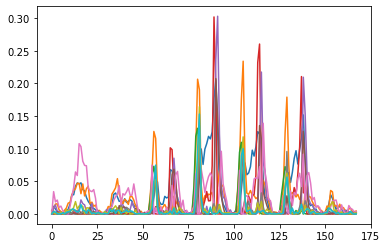

In [130]:
plt.plot(factors[0])

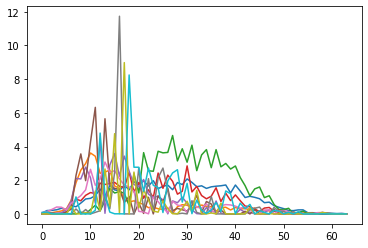

In [126]:
plt.plot(factors[2])